<a href="https://colab.research.google.com/github/bsshreesha/Math_with_Python_UDEMY/blob/main/TF_PINN_Higher_Order_PDEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, I will use **Tensorflow v2** to train a *Physics-Informed Neural Network* (*PINN*) model to solve a second order PDE. Higher-order PDEs are a bit more diffucult than first-order PDEs, because they involve the Hessian Matrix computation. Additionally, the boundary conditions could also be dependent from the derivative of $y$ (also known as *Neumann* BCs), which is of course not known.
The equation I will solve is $\frac{d^2y}{dx^2} = -\pi^2 sin(\pi x)$ with $y(0) = 0$ and $\frac{dy}{dx}(0) = \pi$ for interval $x \in [0, 2 \pi]$ . For evaluation purposes only, we know that the solution of this equation is $y=sin(\pi x)$.

In [14]:
import tensorflow as tf
import numpy as np

In [15]:
num_domain = 1000
num_test = 100
minval = 0
maxval = 2*np.pi

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x_train = generate_uniform_data(num_domain, minval, maxval)
x_test = generate_uniform_data(num_test, minval, maxval)
x_train.shape, x_test.shape

(TensorShape([1000, 1]), TensorShape([100, 1]))

In order to compute the error of our neural network, we are going to have to compute the derivatives of $\frac{dy}{dx}$ and $\frac{d^2y}{dx^2}$. In the previous example, I used the *GradientTape* object to compute Jacobian Matrix of this PDE. In this example, I also need to compute the Hessian Matrix as well.

# Jabocian Matrix

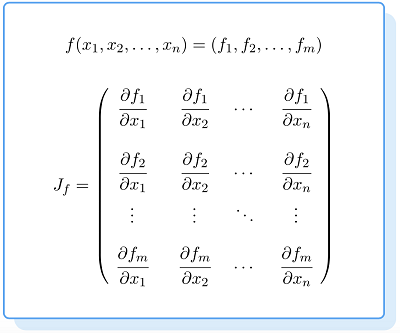

# Hessian Matrix

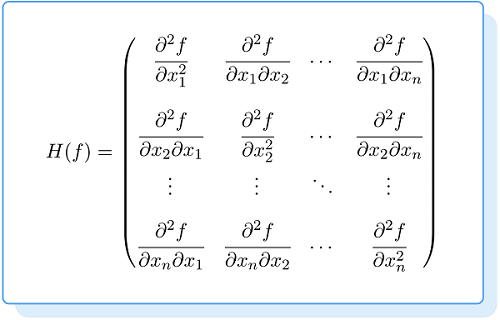

In [16]:
def jacobian(tape, y, x, i=0, j=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  grads = tape.gradient(y, x)
  return grads[:, j : j + 1]

def hessian(tape, y, x, i=0, j=0, component=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  jacobian_grads = tape.gradient(y, x)[:, i : i + 1]
  hessian_grads = tape.gradient(jacobian_grads, x)
  return hessian_grads[:, j : j + 1]

$\frac{d^2y}{dx^2} = -\pi^2 sin(\pi x) \Rightarrow \frac{d^2y}{dx^2} + \pi^2 sin(\pi x) = 0$

**Domain Loss**: *MSE*($\frac{d^2y}{dx^2} + \pi^2 sin(\pi x)$)

**$BC_1$ Loss**: *MSE*($y(0)$)

**$BC_2$ Loss**: *MSE*($dy(0) - pi$)

Training Loss = Domain Loss + $BC_1$ Loss + $BC_1$ Loss

In [17]:
def pde(tape, x, y):
  dyy_x = hessian(tape, y, x)
  return dyy_x + np.pi**2 * tf.sin(np.pi*x)

def dirichlet_bc_0(x):
  return 0

def neumann_bc_2pi(x):
  return np.pi

x_0 = tf.Variable([[0]], trainable=True, dtype=tf.float32)

In [18]:
n_inputs = 1
n_outputs = 1
hidden_units = [50, 50, 50]
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  model.add(tf.keras.layers.Dense(units=units, activation=activation))

model.add(tf.keras.layers.Dense(units=n_outputs))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 50)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 10000
learning_rate = 0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    with tf.GradientTape() as neumann_tape:
      y_0 = model(x_0, training=True)
      dy_0 = neumann_tape.gradient(y_0, x_0)[0][0]
      bc2_error = dy_0 - neumann_bc_2pi(x_0)

    with tf.GradientTape(persistent=True) as tape_pde:
      y = model(x_train, training=True)
      y_0 = model(x_0, training=True)[0][0]

      domain_error = pde(tape_pde, x_train, y)
      bc1_error = y_0 - dirichlet_bc_0(x_0)

    domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
    bc1_mse =  tf.math.square(bc1_error)
    bc2_mse = tf.math.square(bc2_error)
    total_mse = domain_mse + bc1_mse + bc2_mse

  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )

  del tape_pde

  if i % 1000 == 0:
    y_preds = model(x_test)
    test_mse = tf.math.reduce_mean(tf.math.square(y_preds - tf.math.sin(np.pi*x_test)), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()[0]))

Epoch: 0	Train Loss = 55.23006820678711,	Test Loss = 1.4309539794921875
Epoch: 1000	Train Loss = 2.8862783908843994,	Test Loss = 3.9935290813446045
Epoch: 2000	Train Loss = 0.019743725657463074,	Test Loss = 0.6622594594955444
Epoch: 3000	Train Loss = 0.012854021042585373,	Test Loss = 0.3229755759239197
Epoch: 4000	Train Loss = 0.0028739122208207846,	Test Loss = 0.107807457447052
Epoch: 5000	Train Loss = 0.0017291844123974442,	Test Loss = 0.0074959397315979
Epoch: 6000	Train Loss = 0.005221412982791662,	Test Loss = 0.0006569358520209789
Epoch: 7000	Train Loss = 0.0006306704017333686,	Test Loss = 0.0028740819543600082
Epoch: 8000	Train Loss = 0.0004939656355418265,	Test Loss = 0.00266586453653872
Epoch: 9000	Train Loss = 0.00039046909660100937,	Test Loss = 0.0018561999313533306
Epoch: 10000	Train Loss = 0.0002921417180914432,	Test Loss = 0.001145204878412187


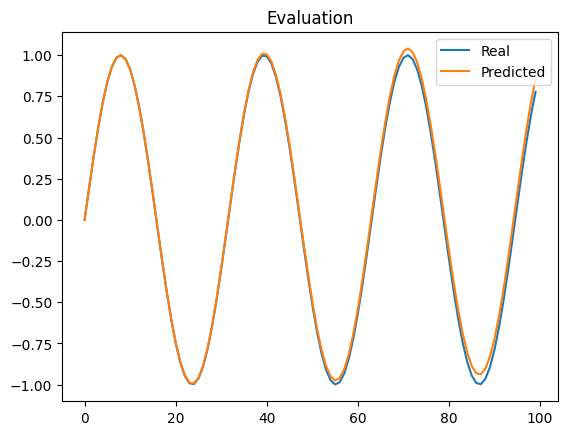

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x_test = np.linspace(0, 2*np.pi, 100)
y_true = np.sin(np.pi*x_test)
y_pred = model(x_test)

plt.plot(y_true)
plt.plot(y_pred)
plt.title('Evaluation')
plt.legend(['Real', 'Predicted'])
plt.show()